In [230]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(11)
sns.set()
%matplotlib inline

# Introduction
In this notebook, I'll be be using a database of credit card transactions to build an accurate predictor of whether a transaction is fraudulent.  The dataset, downloaded from Kaggle, is described in detail below.

Thinkful's instructions: "Using this credit card fraud dataset develop an algorithm to predict fraud. Prioritize correctly finding fraud rather than correctly labeling non-fraudulent transactions."  In light of this, my best metric will be the F1-score, since it doesn't take the number of true negatives into account (whereas an evenly balanced metric like theMatthews Coefficient does).


# About the data

From Kaggle:

"The dataset contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

"It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise."

It's particularly noteworthy that the dataset does not include an identity feature (so that pattern analysis could be personalized to each user).  The source does not specify whether this was included in the raw data (before PCA) or whether a version of PCA was used that could include a categorical variable of that nature.

# Methods

To begin with, I'll try a few general classifiers out of the box: logistic regression, random forest, and gradient boost.  Then I'll try a couple specific anomaly detection algorithms.  Of these models, I'll take the model that seems to be performing best and tweak it for optimization.

Because the data is already a aset of Principal Components (except for Amount and Time), there's no real opportunity for feature engineering, so my experimentations here will all be algorithmic.

# Load and examine

In [14]:
credit_df = pd.read_csv("practice/creditcard.csv")

In [15]:
print(credit_df.shape)
credit_df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [16]:
credit_df.isnull().sum().sum()

0

In [17]:
print("Mean transaction amount (Euros): ", round(credit_df.Amount.mean(), 2))
print("Median transaction amount (Euros): ", credit_df.Amount.median())

Mean transaction amount (Euros):  88.35
Median transaction amount (Euros):  22.0


In [231]:
from sklearn.model_selection import train_test_split
X = credit_df.drop('Class', axis=1)
y = credit_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Initial model trials

## Model 1: logistic regression

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

lreg = LogisticRegression(penalty='l2')
lreg.fit(X_train, y_train)
train_pred = lreg.predict(X_train)
test_pred = lreg.predict(X_test)

false_neg = sum((y_test - test_pred) == -1)
false_pos = sum((y_test - test_pred) == 1)
print("Train score: ", round(f1_score(y_train, train_pred), 3))
print("Test score: ", round(f1_score(y_test, test_pred),3))
print("False negatives: ", false_neg)
print('False positives: ', false_pos)

Train score:  0.63
Test score:  0.67
False negatives:  33
False positives:  45


## Model 2: Random Forest

In [67]:
from sklearn.ensemble import RandomForestClassifier
from time import time
start = time()

rfc = RandomForestClassifier(n_estimators=20)
rfc.fit(X_train, y_train)
train_pred = rfc.predict(X_train)
test_pred = rfc.predict(X_test)

false_neg = sum((y_test - test_pred) == -1)
false_pos = sum((y_test - test_pred) == 1)
print("Train score: ", round(f1_score(y_train, train_pred), 3))
print("Test score: ", round(f1_score(y_test, test_pred),3))
print("False negatives: ", false_neg)
print('False positives: ', false_pos)
print('Elapsed time (s): ', time()-start)

Train score:  0.98
Test score:  0.87
False negatives:  4
False positives:  25
Elapsed time (s):  46.73529767990112


## Model 3: Gradient Boosted Tree

In [234]:
from sklearn.ensemble import GradientBoostingClassifier
start = time()

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
train_pred = gbc.predict(X_train)
test_pred = gbc.predict(X_test)

false_pos = sum((y_test - test_pred) == -1)
false_neg = sum((y_test - test_pred) == 1)
print("Train score: ", round(f1_score(y_train, train_pred), 3))
print("Test score: ", round(f1_score(y_test, test_pred),3))
print("False negatives: ", false_neg)
print('False positives: ', false_pos)
print('Elapsed time (s): ', time()-start)

Train score:  0.827
Test score:  0.82
False negatives:  36
False positives:  8
Elapsed time (s):  132.13475608825684


## Model 4: Isolated Forest

In [199]:
from sklearn.ensemble import IsolationForest
start = time()
fraud_ratio = y_train.sum()/len(y_train)
iso = IsolationForest(n_estimators=200, contamination=fraud_ratio, bootstrap=True)
iso.fit(X_train, y_train)
train_pred = iso.predict(X_train)
test_pred = iso.predict(X_test)

# convert +1/-1 output to 1/0:
train_pred = (1-train_pred)/2
test_pred = (1-test_pred)/2

false_pos = sum((y_test - test_pred) == -1)
false_neg = sum((y_test - test_pred) == 1)
print("Train score: ", round(f1_score(y_train, train_pred), 3))
print("Test score: ", round(f1_score(y_test, test_pred),3))
print("False negatives: ", false_neg)
print('False positives: ', false_pos)
print('Elapsed time (s): ', time()-start)

Train score:  0.292
Test score:  0.256
False negatives:  94
False positives:  109
Elapsed time (s):  55.993184089660645


## Model 5: Local Outlier Factor

In [118]:
from sklearn.neighbors import LocalOutlierFactor
start = time()
lof = LocalOutlierFactor(contamination=fraud_ratio)
pred = lof.fit_predict(X)

# convert +1/-1 output to 1/0:
pred = (1-pred)/2

print("Score: ", round(f1_score(y, pred), 3))
print('Elapsed time (s): ', time()-start)

Score:  0.05


# Model choice conclusions

Bafflingly, while the Random Forest and Gradient Boosted Trees performed pretty well straight out of the box, both of the specific anomaly detection models scored miserably low (f1-scores of 0.26 and 0.05).  Why are these performing so badly?

Probably the next logical outlier detectio nmodel to try would be a One-Class SVM. However, given the dismal results of anomaly detection algorithms so far, for the purposes of this exercise I'm going to run with Random Forest and Gradient Boosted Tree and try some optimization.

# Optimizing Random Forest

First, let's run a hyperparameter sweep and see what we get.

In [119]:
# report utility function from http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [138]:
from sklearn.model_selection import RandomizedSearchCV

rfc_2 = RandomForestClassifier()

param_dist = {"n_estimators":[40],
              "random_state":[11],
              "max_depth": [4,8,20],
              "max_features": [6,9,12,20],
              "min_samples_split": [2,10,20],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]
}

random_search = RandomizedSearchCV(rfc_2, param_distributions=param_dist, n_iter=25)
start = time()
random_search.fit(X_train, y_train)

print("Elapsed seconds: ", time()-start)
report(random_search.cv_results_, n_top=3)

Elapsed seconds:  7492.5006330013275
Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'random_state': 11, 'n_estimators': 40, 'min_samples_split': 10, 'max_features': 9, 'max_depth': 20, 'criterion': 'entropy', 'bootstrap': False}

Model with rank: 2
Mean validation score: 1.000 (std: 0.000)
Parameters: {'random_state': 11, 'n_estimators': 40, 'min_samples_split': 2, 'max_features': 9, 'max_depth': 20, 'criterion': 'entropy', 'bootstrap': True}

Model with rank: 2
Mean validation score: 1.000 (std: 0.000)
Parameters: {'random_state': 11, 'n_estimators': 40, 'min_samples_split': 2, 'max_features': 12, 'max_depth': 20, 'criterion': 'gini', 'bootstrap': False}



It looks like we have several equally good scores that are all somewhat overfit.  Let's take these general parameters and look at our test score, false negatives, and false positives.

In [200]:
start = time()

params = {'random_state': 11, 
          'n_estimators': 40, 
          'min_samples_split': 10, 
          'max_features': 9, 
          'max_depth': 20, 
          'criterion': 'entropy', 
          'bootstrap': False}

rfc_opt = RandomForestClassifier(**params)
rfc_opt.fit(X_train, y_train)
train_pred = rfc_opt.predict(X_train)
test_pred = rfc_opt.predict(X_test)

false_pos = sum((y_test - test_pred) == -1)
false_neg = sum((y_test - test_pred) == 1)
print("Train score: ", round(f1_score(y_train, train_pred), 3))
print("Test score: ", round(f1_score(y_test, test_pred),3))
print("False negatives: ", false_neg)
print('False positives: ', false_pos)
print('Elapsed time (s): ', time()-start)

Train score:  1.0
Test score:  0.892
False negatives:  22
False positives:  4
Elapsed time (s):  148.17836117744446


The good news here is that our f1-score is pretty solid at 89%.  The bad news is that we still have 22 false negatives (out of 129 actual negatives), which means we're misidentifying 17% of fraudulent transactions.  Given the cost of failing to identify fraudulent transactions, this 83% fraud detection probably isn't good enough.

We may be able to improve on this by changing our algorithm.  By adjusting the class weights of the random tree, we can heavily prioritize correctly identifying positive cases (the minority case) over negative cases.  Let's try over-weighting fraud identification by increasing powers of 10 and see what happens to our false negatives and our f1-scores.

In [214]:
start = time()
scores = []
false_neg_counts = []
false_pos_counts = []
balance_exps = [0, 2, 4, 6, 8, 10, 12]
for balance_exp in balance_exps:
    params = {'random_state': 11, 
              'n_estimators': 20, 
              'min_samples_split': 10, 
              'max_features': 9, 
              'max_depth': 20, 
              'criterion': 'entropy', 
              'bootstrap': False,
              'class_weight': {0:1, 1:10**balance_exp}
             }

    rfc = RandomForestClassifier(**params)
    rfc.fit(X_train, y_train)
    train_pred = rfc.predict(X_train)
    test_pred = rfc.predict(X_test)

    false_neg_counts.append( sum((y_test - test_pred) == 1) )
    false_pos_counts.append( sum((y_test - test_pred) == -1) )
    scores.append( round(f1_score(y_train, train_pred), 3) )

print('Elapsed time (s): ', time()-start)

Elapsed time (s):  429.8313000202179


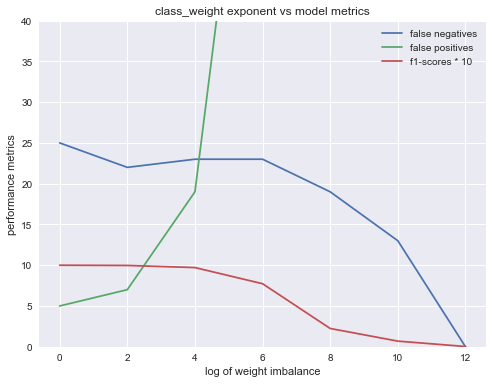

In [216]:
plt.figure(figsize=(8,6))
plt.plot(balance_exps, false_neg_counts, label='false negatives')
plt.plot(balance_exps, false_pos_counts, label='false positives')
plt.plot(balance_exps, [s*10 for s in scores], label='f1-scores * 10')
plt.title("class_weight exponent vs model metrics")
plt.xlabel('log of weight imbalance')
plt.ylabel('performance metrics')
plt.legend()
plt.ylim(0,40)
plt.show()

It looks like the tradeoff in accuracy is way too steep here: our f1-score drops below 0.5 before we see any significant reduction in false negatives.

For now, then, our best try is 83% fraud detection with an f1-score of 89%.  Let's table that for now and try optimizing our gradient boosted tree model.

# Optimizing Gradient Boosted Tree

We'll start by optimizing all parameters except the computation-intensive n_estimators and learning_rate, then hold the others constant while we tweak those two.

In [141]:
from sklearn.model_selection import RandomizedSearchCV
from time import time

gbc_2 = GradientBoostingClassifier()

param_dist = {
    'loss': ['deviance','exponential'],
    'n_estimators': [50], # we'll change this next time
    'learning_rate': [0.1], # ditto
    'max_depth': [2,4,6,8],
    'max_features': [2,4,6,8],
    'subsample': [0.1, 0.3, 0.6, 1],
    'random_state': [11]
}

random_search = RandomizedSearchCV(gbc_2, param_distributions=param_dist, n_iter=25)
start = time()
random_search.fit(X_train, y_train)

print("Elapsed seconds: ", time()-start)
report(random_search.cv_results_, n_top=3)

Elapsed seconds:  859.3788621425629
Model with rank: 1
Mean validation score: 0.999 (std: 0.000)
Parameters: {'subsample': 1, 'random_state': 11, 'n_estimators': 50, 'max_features': 8, 'max_depth': 6, 'loss': 'exponential', 'learning_rate': 0.1}

Model with rank: 2
Mean validation score: 0.999 (std: 0.000)
Parameters: {'subsample': 1, 'random_state': 11, 'n_estimators': 50, 'max_features': 6, 'max_depth': 6, 'loss': 'exponential', 'learning_rate': 0.1}

Model with rank: 3
Mean validation score: 0.999 (std: 0.000)
Parameters: {'subsample': 0.6, 'random_state': 11, 'n_estimators': 50, 'max_features': 8, 'max_depth': 8, 'loss': 'exponential', 'learning_rate': 0.1}



In [143]:
from sklearn.model_selection import RandomizedSearchCV
from time import time
param_dist = {
    'loss': ['exponential'],
    'n_estimators': [50,100,200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [6],
    'max_features': [6],
    'subsample': [1],
    'random_state': [11]
}

random_search = RandomizedSearchCV(gbc_2, param_distributions=param_dist, n_iter=10)
start = time()
random_search.fit(X_train, y_train)

print("Elapsed seconds: ", time()-start)
report(random_search.cv_results_, n_top=3)

Elapsed seconds:  3412.5153291225433
Model with rank: 1
Mean validation score: 0.999 (std: 0.000)
Parameters: {'subsample': 1, 'random_state': 11, 'n_estimators': 100, 'max_features': 6, 'max_depth': 6, 'loss': 'exponential', 'learning_rate': 0.2}

Model with rank: 1
Mean validation score: 0.999 (std: 0.000)
Parameters: {'subsample': 1, 'random_state': 11, 'n_estimators': 200, 'max_features': 6, 'max_depth': 6, 'loss': 'exponential', 'learning_rate': 0.2}

Model with rank: 3
Mean validation score: 0.999 (std: 0.000)
Parameters: {'subsample': 1, 'random_state': 11, 'n_estimators': 100, 'max_features': 6, 'max_depth': 6, 'loss': 'exponential', 'learning_rate': 0.1}

Model with rank: 3
Mean validation score: 0.999 (std: 0.000)
Parameters: {'subsample': 1, 'random_state': 11, 'n_estimators': 200, 'max_features': 6, 'max_depth': 6, 'loss': 'exponential', 'learning_rate': 0.05}



In [232]:
start = time()
params = {'random_state': 11, 'n_estimators': 100, 'max_features': 6, 'max_depth': 6, 'loss': 'exponential', 'learning_rate': 0.2}

gbc_3 = GradientBoostingClassifier(**params)
gbc_3.fit(X_train, y_train)
train_pred = gbc_3.predict(X_train)
test_pred = gbc_3.predict(X_test)

false_pos = sum((y_test - test_pred) == -1)
false_neg = sum((y_test - test_pred) == 1)
print("Train score: ", round(f1_score(y_train, train_pred), 3))
print("Test score: ", round(f1_score(y_test, test_pred),3))
print("False negatives: ", false_neg)
print('False positives: ', false_pos)
print('Elapsed time (s): ', time()-start)

Train score:  0.983
Test score:  0.876
False negatives:  27
False positives:  4
Elapsed time (s):  90.07184290885925


We can see that gradient boosted tree will yield basically the same results as random forest.  Since these results have one fewer false negative, we'll use gradient boosted tree as our top performer moving forward.  But they're basically identical.

## Final boosted tree test

Our best model on our test set has been our gradient boosted tree.  Let's make sure this replicates across different random splits of our data (i.e., make sure it's not overfit to our test set).

In [236]:
start = time()

false_neg_counts = []
false_pos_counts = []
scores = []

for i in range(4):
    random.seed(a=None)
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.25)

    start = time()
    params = {'random_state': 11, 'n_estimators': 100, 'max_features': 6, 'max_depth': 6, 'loss': 'exponential', 'learning_rate': 0.2}

    gbc_4 = GradientBoostingClassifier(**params)
    gbc_4.fit(X_train, y_train)
    train_pred = gbc_4.predict(X_train)
    test_pred = gbc_4.predict(X_test)
    
    false_pos = sum((y_test2 - test_pred) == -1)
    false_negs = sum((y_test2 - test_pred) == 1)
    score = round(f1_score(y_test2, test_pred),3)
    
    false_pos_counts.append(false_pos)
    false_neg_counts.append(false_negs)
    scores.append(score)
    
print("False negatives mean: ", round(np.mean(false_neg_counts),3) )
print("False negatives variance: ", round(np.var(false_neg_counts),3) )
print("False positives mean: ", round(np.mean(false_pos_counts),3) )
print("Mean f1-score:", round(np.mean(scores), 3) )
print('Elapsed time (s): ', time()-start)
random.seed(11)

False negatives mean:  128.5
False negatives variance:  30.25
False positives mean:  112.75
Mean f1-score: 0.002
Elapsed time (s):  85.12541890144348


In [235]:
false_neg_counts

[113, 130, 123, 123]

Why on earth are these results coming back like this?  Why is the time so short, and why are the metrics so bad?  I've read through this line by line twice and can't make heads or tails of it.  For the moment, I'll stick with the results of the previous single test.

# Conclusions

In light of these results, my recommendation would probably be for the bank in this case to adopt a hybrid model.

The primary model would be the gradient boosted tree above, which catches 83% of fraudulent transactions with an almost nonexistent rate of false positives.  Transactions flagged by this fraud detector should be denied.

The secondary should be a model that flags nearly all of the fraudulent transactions at the cost of also incorrectly flagging many non-fraudulent transactions.  We might, for instance, use our heavily weighted random forest model, which flagged 94% of fraudulent transactions, at the cost of having 98% of its flags were false flags.  For transactions flagged only by the seondary model, the transaction should only be denied if it is above a certain amount (e.g., 2,000 USD) above which the risk of a fraudulent transaction is unacceptable, or if it is the third or more consecutive secondary-flagged transaction (which would only occur in approximately 0.1 percent of all transactions).

Together, these models will catch 83% of fraudulent transactions, and halt an additional 11% of fraudulent transactions if they are large transactions.

# Questions

<ol>
    <li>Why do the specific outlier factors (Local Outlier Factor and One-class SVM) perform so badly here?</li>
     <li>What's going on with the haywire results of the final boosted tree test above?</li>
    <li>It strikes me that this is a case where I probably should have divided my dataset three ways into a training set, cv set, and test set, rather than a simple train_test split.  I compensated for this by testing against several new random splits at the end, which is almost (but not totally) as good.  Should I have done a three-way split here?  Should I usually do a three-way split?</li>
    <li>Why do the weight adjustments below not behave as expected?  Are there better ways to prioritize eliminating false positives?  (I get the impression that thresholding is not ideal.  And according to this paper, weighting and subsampling perform almost identically: http://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf)</li>
</ol>
    

## Everything below here is scratch -- ignore

Stacking experiments

In [145]:
# stack 1: final boost like boosted tree
rfc = RandomForestClassifier(n_estimators=40)
rfc.fit(X_train, y_train)
train_pred = rfc.predict(X_train)
test_pred = rfc.predict(X_test)
errors = train_pred-y_train

rfc2 = RandomForestClassifier(n_estimators=40)
rfc2.fit(X_train, errors)
error_train_pred = rfc2.predict(X_train)
error_test_pred = rfc2.predict(X_test)

final_train_pred = train_pred - error_train_pred
final_test_pred = test_pred - error_test_pred
print("Train score: ", round(f1_score(y_train, final_train_pred), 3))
print("Test score: ", round(f1_score(y_test, final_test_pred),3))


Train score:  1.0
Test score:  0.87


TRY STACKING HERE (one boost after the RF - or more?)

also JUST REALIZED that NNs are just stacked linear regressions.  What happens if you stack RFs in multiple layers???

OR BETTER YET: figure out how to combine RFs into a NN-analogous structure
A backprop equivalent is, I think, the key here.  Could you use something like gradient boost?

In [ ]:
# stack 2: use outputs from trees as input
# part 1: generate tree predictions
train_predictions = []
test_predictions = []
forests = 20
for i in range(forests):
    rfc = RandomForestClassifier(n_estimators=5)
    rfc.fit(X_train, y_train)
    train_predictions.append(rfc.predict(X_train))
    test_predictions.append(rfc.predict(X_test))

In [ ]:
# experimental part 3: double-stack, like a NN
train_predictions2 = []
test_predictions2 = []
forests = 20
for i in range(forests):
    rfc = RandomForestClassifier(n_estimators=5)
    rfc.fit(train_predictions, y_train)
    train_predictions2.append(rfc.predict(train_predictions))
    test_predictions2.append(rfc.predict(test_predictions))

In [ ]:
# part 2: train model on those predictions
rfc = RandomForestClassifier(n_estimators=80)
rfc.fit(predictions, y_train)
train_pred = rfc.predict(train_predictions)
test_pred = rfc.predict(test_predictions)

false_pos = sum((y_test - test_pred) == -1)
false_neg = sum((y_test - test_pred) == 1)
print("Train score: ", round(f1_score(y_train, train_pred), 3))
print("Test score: ", round(f1_score(y_test, test_pred),3))
print("False negatives: ", false_neg)
print('False positives: ', false_pos)

For fun, take just the top two PCs and plot the gradient and shape as in the sklearn examples.  This might also help diagnose the problems with my anomaly detection algorithms.